In [1]:
import copy
import os
import random
import uuid
from dataclasses import asdict, dataclass
from pathlib import Path

%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt

import yaml
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal

import sys
sys.path.append('../scripts')
from tensordict import MemoryMappedTensor, TensorDict

from actor_utils import *
from utils import *

In [2]:
checkpoints_path = "/home/lucas/Workspace/CORL/out"
run_name = "BC-evasion-v2"
model_dict = torch.load(os.path.join(checkpoints_path, run_name, "checkpoint_3049999.pt"))

In [3]:
with open(os.path.join(checkpoints_path, run_name, "config.yaml"),"r") as file_object:
    config = yaml.load(file_object,Loader=yaml.SafeLoader)

In [4]:
# Set environment parameters.
img_size = config['env']['img_size']
time_max = config['env']['max_time_step']
observation_img_size = [1, img_size, img_size]
action_dim = config['env']['action_dim']
action_space = gym.spaces.Box(low=-1.0, high=1.0, shape=(action_dim,))
map_size = config['env']['map_size']
if config['env']['observation']['goal_direction_normalized']:
    observation_space= gym.spaces.Dict({"heat_map": gym.spaces.Box(0, 255, observation_img_size), 
                            "goal_direction": gym.spaces.Box(-1, 1, shape=(2,))})
                            # 'time_spent': gym.spaces.Box(low=1.0, high=np.inf, shape=(1,))})
else:
    observation_space= gym.spaces.Dict({"heat_map": gym.spaces.Box(0, 255, observation_img_size), 
                            "goal_direction": gym.spaces.Box(-map_size / 2.0, map_size / 2.0, shape=(2,))})
                            # 'time_spent': gym.spaces.Box(low=1.0, high=np.inf, shape=(1,))})

In [5]:
model_dict

{'actor': OrderedDict([('log_std', tensor([-10.9836], device='cuda:0')),
              ('feature_extractor.extractors.heat_map.cnn.0.weight',
               tensor([[[[-1.0685e-01, -7.2221e-02, -2.7780e-02,  ..., -1.1902e-01,
                          -1.8012e-02,  1.4030e-01],
                         [ 1.9104e-02, -1.4886e-02, -3.0262e-02,  ...,  3.9840e-02,
                          -3.5945e-02,  6.6826e-02],
                         [-1.8434e-01, -1.0826e-01, -1.7437e-01,  ..., -7.8998e-02,
                           4.5284e-02,  1.2169e-01],
                         ...,
                         [ 1.0541e-02, -1.3859e-02, -8.7983e-02,  ..., -1.3116e-01,
                           1.2240e-01,  1.1611e-01],
                         [-1.5538e-01, -1.4090e-01, -1.7083e-01,  ..., -1.7612e-02,
                           2.6399e-02,  1.6418e-01],
                         [-1.0779e-01, -4.1052e-03, -2.6832e-02,  ...,  8.6937e-02,
                           4.7439e-02,  6.7337e-02]]],
    

### Load Actor ###

In [6]:
assert config['policy']['hidden_act'] == 'Tanh' or config['policy']['hidden_act'] == 'ReLU', "Currently only support ReLU or Tanh."
if config['policy']['hidden_act'] == 'Tanh':
    actor = ActorNet(observation_space, action_space, config['policy']['actor_net_hidden'], hidden_act=nn.Tanh)
if config['policy']['hidden_act'] == 'ReLU':
    actor = ActorNet(observation_space, action_space, config['policy']['actor_net_hidden'], hidden_act=nn.ReLU)
actor.load_state_dict(model_dict['actor'])
actor.eval()

ActorNet(
  (feature_extractor): FeatureExtractor(
    (extractors): ModuleDict(
      (goal_direction): Flatten(start_dim=1, end_dim=-1)
      (heat_map): NatureCNN(
        (cnn): Sequential(
          (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
          (1): ReLU()
          (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
          (3): ReLU()
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          (5): ReLU()
          (6): Flatten(start_dim=1, end_dim=-1)
        )
        (linear): Sequential(
          (0): Linear(in_features=28224, out_features=256, bias=True)
          (1): ReLU()
        )
      )
    )
  )
  (policy_net): Sequential(
    (0): Linear(in_features=258, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (action_net): Linear(in_features=64, out_features=1, bias=True)
)

### Load one of the training data ###

In [7]:
delta_t = config['env']['delta_t']
V = config['env']['V']
radar_radius = config['env']['radar_radius']
aircraft_detection_range = config['env']['aircraft_detection_range']
grid_size=2*aircraft_detection_range/img_size
time_scaling = config['env']['observation']['time_scaling']
action_rescaling = config['env']['action_max']

In [8]:
episode_idx = 0
data_path = "/home/lucas/Workspace/evasion_guidance/evasion_guidance/data/"
episode_dict = np.load(data_path + f'episode_{episode_idx}.npy',allow_pickle='TRUE').item()

state_cur = episode_dict['start_state']
radar_locs = episode_dict['radar_locations']
radar_orientations = episode_dict['radar_orientations']
goal_location = episode_dict['goal_location']


time_spent = 0

trajectory = [state_cur]
q_values = []
with torch.no_grad():
    # while np.linalg.norm(state_cur[:2] - goal_location) > config['env']['goal_tolerance']:
    for i in range(len(episode_dict['state_history'])):
        # print("Time spent: ", time_spent)
        if time_spent % 10 == 0:
            print("Time spent: ", time_spent)
        if time_spent > config['env']['max_time_step']:
            print("Reached time limit.")
            break
        heat_map = get_radar_heat_map(state_cur, radar_locs, img_size,
                                           aircraft_detection_range,
                                           grid_size, 
                                           radar_radius)
        
        goal_direction = center_state(state_cur, goal_location) / (map_size / 2.0)
        
        obs = TensorDict({
            'heat_map': torch.from_numpy(heat_map).unsqueeze(dim=0).float(),
            'goal_direction': torch.from_numpy(goal_direction).unsqueeze(dim=0).float()
            # 'time_spent': torch.from_numpy(np.asarray([np.exp(time_spent/time_scaling)])).unsqueeze(dim=0).float()
        })

        u, _ = actor(obs)
        u = action_rescaling*u
        state_cur = state_cur + delta_t*np.array([V*np.cos(state_cur[2]), V*np.sin(state_cur[2]), u.flatten().numpy()[0]/V])
        time_spent += 1
        # print(state_cur)
        trajectory.append(state_cur)
trajectory = np.asarray(trajectory)

Time spent:  0
Time spent:  10
Time spent:  20
Time spent:  30
Time spent:  40


In [9]:
# img_size = 200
# aircraft_detection_range=100
# grid_size=2*aircraft_detection_range/img_size
# heat_map = get_radar_heat_map(episode_dict['start_state'], radar_locs, img_size, aircraft_detection_range, grid_size, radar_radius)
        

In [10]:
# plt.close()
# plt.imshow(heat_map.squeeze(), cmap='hot', interpolation='nearest', origin="lower")
# plt.show()

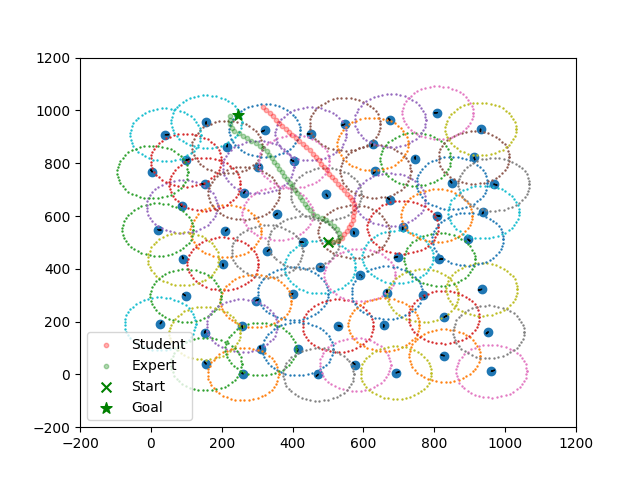

In [11]:
plt.close()
fig, ax = plt.subplots()
visualiza_radar_config(radar_locs, radar_orientations, radius=radar_radius, xlim=[0, map_size], ylim=[0, map_size])


ax.scatter(trajectory[:, 0], trajectory[:, 1], s=10, c='r', alpha=0.3, label='Student')
ax.scatter(episode_dict['state_history'][:, 0], episode_dict['state_history'][:, 1], s=10, c='g', alpha=0.3, label='Expert')
ax.scatter(episode_dict['start_state'][0], episode_dict['start_state'][1], s=50, c='g', marker='x', label="Start")
ax.scatter(goal_location[0], goal_location[1], s=70, c='g', marker='*', label='Goal')

ax.set_xlim(-200, 1.2*map_size)
ax.set_ylim(-200, 1.2*map_size)
ax.legend()
plt.show()